# Experiment 1: Various Active Learning Methods
This notebook shows the experiments for running each active learning method with a CNNVAE embedding on each dataset. The underyling acquisition function is uncertainty in each case. This corresponds to the "Time consumption and accuracy comparison experiment among different active learning sampling methods" experiment in the paper. The bottom of this document also contains the detailed plots of these experiments (over time). 

Methods:
- LocalMax
- Random
- TopMax
- Acq_Sample
- Sequential

Datasets:
- MSTAR
- OpenSARShip
- FUSAR-Ship

## Make next cell account for stuff being on google colab

# TODO: 
1. Make next cell for google colab stuff
2. Make the percentages show on the top of the plot (make sure ticks still in right spot)
3. Put markers on the points for the plots
4. I keep getting an error in the coreset_run_experiment function when Random gets called. It says that we're trying to take a batch larger than the number of points left. 

## TODO: SOMETHING WIERD with fusar plot
Also the things have different numbers of points...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphlearning as gl

import batch_active_learning as bal
import utils

# TODO: Need to get the parameters correct for bal.run_coreset_experiment

## Parameters and Function Definitions

In [2]:
#Non-default Parameters

acq_fun_list = ['uc']
save_path = "Experiment Results/Experiment 1/"

In [3]:
def experiment1(dataset):
    assert dataset in utils.AVAILABLE_SAR_DATASETS, "Invalid dataset"

    max_new_samples = bal.MAX_NEW_SAMPLES_DICT[dataset]

    X, labels, knn_data = utils.CNNVAE(dataset)

    # Create graph objects
    W = gl.weightmatrix.knn(X, utils.KNN_NUM, kernel="gaussian", knn_data=knn_data)
    G = gl.graph(W)

    # Do experiment for each method
    time_dict = {}
    acc_dict = {}
    num_labels_dict = {}
    full_acc_dict = {}

    # Ensure each label is represented in core set
    initial = gl.trainsets.generate(labels, rate=1).tolist()

    # Construct coreset
    coreset = bal.coreset_dijkstras(
        G,
        rad=bal.DENSITY_RADIUS,
        data=X,
        initial=initial,
        density_info=(True, bal.DENSITY_RADIUS, 1),
        knn_data=knn_data,
    )

    for al_mtd in bal.AL_METHODS:
        if al_mtd == "global_max":
            num_iter = max_new_samples
        else:
            num_iter = max_new_samples // bal.BATCH_SIZE

        # Run experiment
        _, num_labels, acc_vals, al_time = bal.coreset_run_experiment(
            X,
            labels,
            W,
            coreset,
            num_iter=num_iter,
            method="Laplace",
            display=False,
            use_prior=False,
            al_mtd=al_mtd,
            acq_fun="uc",
            knn_data=knn_data,
            mtd_para=None,
            savefig=False,
            batchsize=bal.BATCH_SIZE,
            dist_metric="angular",
            knn_size=utils.KNN_NUM,
            q=1,
            thresholding=0,
        )

        time_dict[al_mtd] = al_time
        acc_dict[al_mtd] = acc_vals[-1]
        num_labels_dict[al_mtd] = np.array(num_labels)
        full_acc_dict[al_mtd] = np.array(acc_vals)

    return acc_dict, time_dict, num_labels_dict, full_acc_dict


def experiment1_simple_plotter(x_dict, y_dict, dataset, include_sota=False):

    for ind, this_key in enumerate(bal.AL_METHODS):
        plt.plot(x_dict[this_key], y_dict[this_key], label=bal.AL_METHOD_NAMES[ind])

    plt.xlabel("Number of Labeled Points")
    plt.ylabel("Accuracy (%)")

    plt.tick_params(axis="x")

    # Add SoTA
    if dataset != "mstar" and include_sota:
        if dataset == "open_sar_ship":
            sota_val = 78.15
        elif dataset == "fusar":
            sota_val = 86.69
        plt.plot(
            x_dict["local_max"],
            sota_val * np.ones_like(x_dict["local_max"]),
            label="SoTA",
            linestyle="--",
        )

    plt.legend()
    plt.tight_layout()

    file_path = save_path + dataset + "_detailed_plot"
    if include_sota:
        file_path += "_sota"
    file_path += ".png"

    # plt.savefig(file_path, bbox_inches='tight')
    plt.show()
    return


def full_save(acc_dict, time_dict, num_labels_dict, full_acc_dict, dataset):
    new_save_path = save_path + "Pickles/" + dataset
    print("Saving to: " + save_path + "Pickles/")

    df_acc_dict = pd.DataFrame.from_dict(acc_dict, orient="index")
    df_acc_dict.to_pickle(new_save_path + "_acc_dict.pkl")

    df_time_dict = pd.DataFrame.from_dict(time_dict, orient="index")
    df_time_dict.to_pickle(new_save_path + "_time_dict.pkl")

    df_num_labels_dict = pd.DataFrame.from_dict(num_labels_dict, orient="index")
    df_num_labels_dict.to_pickle(new_save_path + "_num_labels_dict.pkl")

    df_full_acc_dict = pd.DataFrame.from_dict(full_acc_dict, orient="index")
    df_full_acc_dict.to_pickle(new_save_path + "_full_acc_dict.pkl")

    return

## Experiments

In [4]:
acc_mstar, time_mstar, num_labels_mstar, full_acc_mstar = experiment1('mstar')

Using pre-computed cnnvae embedding knn_data


In [5]:
acc_open_sar, time_open_sar, num_labels_open_sar, full_acc_open_sar = experiment1('open_sar_ship')

Using pre-computed cnnvae embedding knn_data


In [6]:
acc_fusar, time_fusar, num_labels_fusar, full_acc_fusar = experiment1('fusar')

Using pre-computed cnnvae embedding knn_data


## Accuracy Results

In [7]:
#Create pandas dataframe
acc_results = {'mstar': acc_mstar, 'open_sar_ship': acc_open_sar, 'fusar': acc_fusar}
df_acc = pd.DataFrame.from_dict(acc_results, orient='index')

#Save
df_acc.to_pickle(save_path + 'Pickles/accuracy_table.pkl')

#Display data
print("Accuracy")
print(df_acc)

Accuracy
               local_max     random   topn_max  acq_sample  global_max
mstar          98.850032  87.429112  98.708255   89.350977   99.417047
open_sar_ship  91.056384  77.496757  90.402075   82.101167   91.569390
fusar          90.014333  73.954984  91.961415   80.771704   93.311897


## Time Results

In [8]:
#Create pandas dataframe
time_results = {'mstar': time_mstar, 'open_sar_ship': time_open_sar, 'fusar': time_fusar}
df_time = pd.DataFrame.from_dict(time_results, orient='index')

#Save
df_time.to_pickle(save_path + 'Pickles/time_table.pkl')

#Display data
print("Time")
print(df_time)

Time
               local_max     random   topn_max  acq_sample  global_max
mstar          12.359105  14.201411  12.437965   12.479982  140.272815
open_sar_ship   3.960766   4.350396   4.178685    4.128163   34.675628
fusar          25.912768  23.924063  25.993391   22.876236  283.924062


## MSTAR Detailed Plots

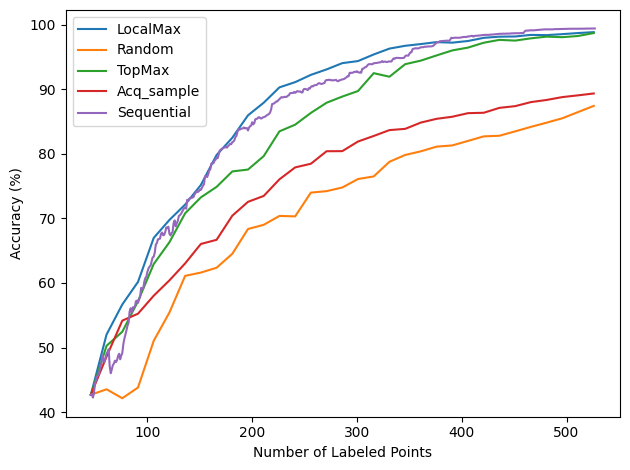

In [9]:
experiment1_simple_plotter(num_labels_mstar, full_acc_mstar, dataset='mstar')

## OpenSARShip Detailed Plots

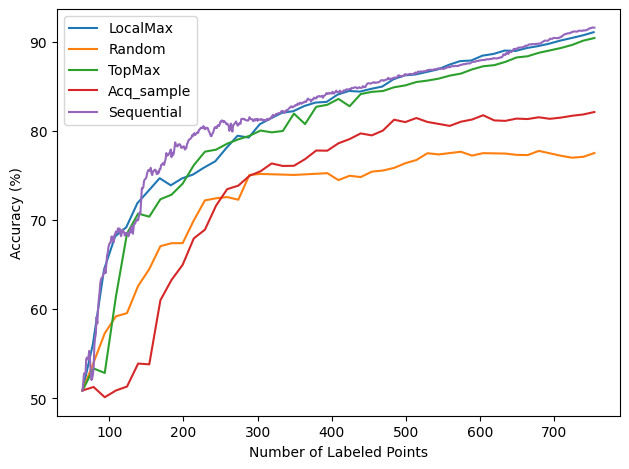

In [10]:
experiment1_simple_plotter(num_labels_open_sar, full_acc_open_sar, dataset='open_sar_ship')

## FUSAR-Ship Detailed Plots

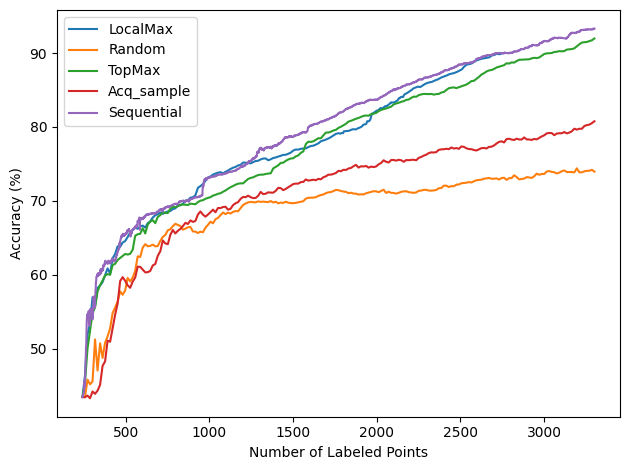

In [11]:
experiment1_simple_plotter(num_labels_fusar, full_acc_fusar, dataset='fusar')

## Saving Plots with SoTA

MSTAR


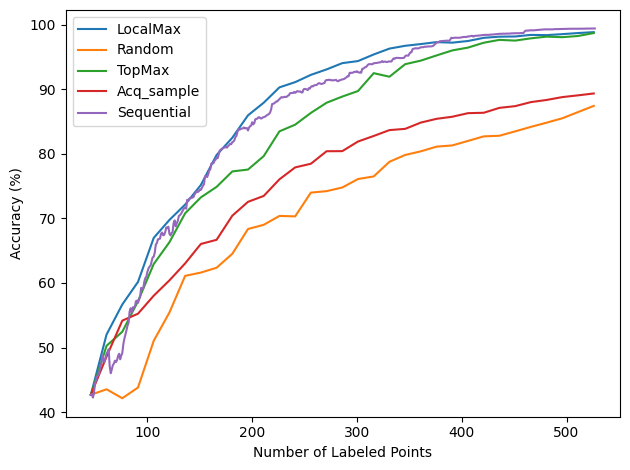

OpenSARShip


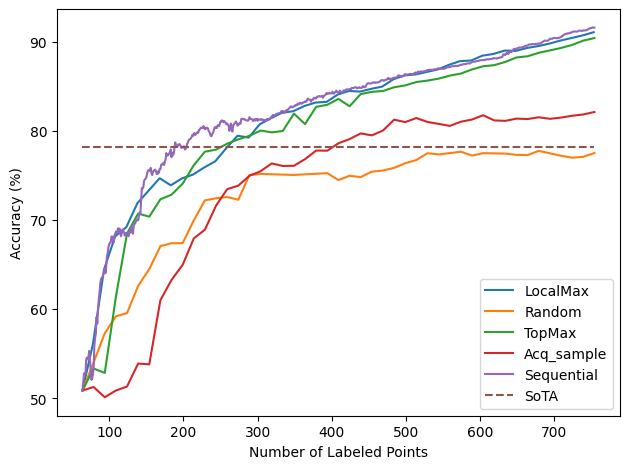

FUSAR-Ship


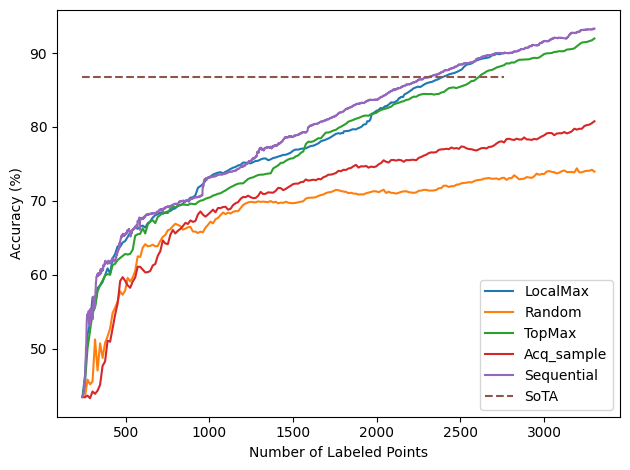

In [12]:
print("MSTAR")
experiment1_simple_plotter(num_labels_mstar, full_acc_mstar, dataset='mstar', include_sota=True)

print("OpenSARShip")
experiment1_simple_plotter(num_labels_open_sar, full_acc_open_sar, dataset='open_sar_ship', include_sota=True)

print("FUSAR-Ship")
experiment1_simple_plotter(num_labels_fusar, full_acc_fusar, dataset='fusar', include_sota=True)

## Save All Data

In [13]:
#MSTAR
full_save(acc_mstar, time_mstar, num_labels_mstar, full_acc_mstar, 'mstar')

#OpenSARShip
full_save(acc_open_sar, time_open_sar, num_labels_open_sar, full_acc_open_sar, 'open_sar_ship')

#FUSAR-Ship
full_save(acc_fusar, time_fusar, num_labels_fusar, full_acc_fusar, 'fusar')

Saving to: Experiment Results/Experiment 1/Pickles/
Saving to: Experiment Results/Experiment 1/Pickles/
Saving to: Experiment Results/Experiment 1/Pickles/
